# PHYS20762 Project 3: Monte Carlo Techniques

## Neutron Transport and Scattering Through a Shielding Layer

Author: 10841151<br>
April 2023

------------------------------------------------------------------------------

Initialisation: importing libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import concurrent.futures

In [3]:
avogadro_const = 6.022 * (10**23)

water_absorption_coeff = 6.652 * (10 ** (-25))#cm^2
water_scattering_coeff = 1.03 * (10 ** (-22))#cm^2
water_density = 1#g/cm^3
water_molar_mass = 18.0153#g/mol

lead_absorption_coeff = 1.58 * (10 ** (-25))#cm^2
lead_scattering_coeff = 1.1221 * (10 ** (-23))#cm^2
lead_density = 11.35#g/cm^3
lead_molar_mass = 207.2#g/mol

graphite_absorption_coeff = 4.5 * (10 ** (-27))#cm^2
graphite_scattering_coeff = 4.74 * (10 ** (-24))#cm^2
graphite_density = 1.67#g/cm^3
graphite_molar_mass = 12.011#g/mol

## Checking the accuracy of 'numpy.random.uniform()'

Initially we want to check that 'numpy.random.uniform()' produces a uniform distribution. We will do this by using 'numpy.random.uniform()' to generate a fixed number of points between 0 and 1, and plot these points in a histogram in order to check their uniformity. We will repeat this test for several numbers of points.

The mean of the values for n = 100 points is -0.11074310289814278
The mean of the values for n = 1000 points is 0.0036352817835095196
The mean of the values for n = 10000 points is -0.007664399450156246
The mean of the values for n = 100000 points is -0.0008825530607257597


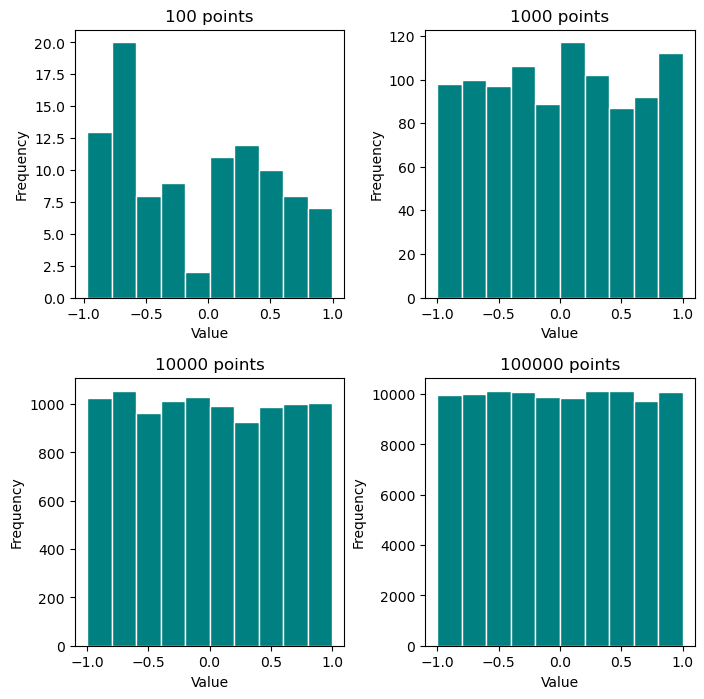

In [4]:
number_of_points_to_test = [100, 1000, 10000, 100000]
histograms_fig = plt.figure(figsize = [8, 8])
uniform_distribution_subplot_grid = gridspec.GridSpec(2, 2, wspace = 0.3, hspace = 0.3)

def generate_random_uniform_points_one_dimension(number_of_points):
    """
    Generates a 2D array of random uniformly distributed points between the values of -1 and 1 using numpy.random.uniform.
    The size of the array in each dimension is given by the number_of_points parameter.
    
    Parameters
    ----------
    number_of_points : float
        A parameter defining how big the 2D array should be. For example, if number_of_points = 10, the output will be a 
        10 x 10 array.
        
    Returns
    -------
    points: array
        A 2D array of uniform randomly distributed points. The size of this array is given by number_of_points.
    """
    
    points = np.random.uniform(low = -1.0, high = 1.0, size = (number_of_points))
    
    return points

for i in range(4):
    #create a flat 1D array of randomly generated points
    test_points = generate_random_uniform_points_one_dimension(number_of_points_to_test[i])
    test_points_array = test_points.flatten()
    
    #plotting the distribution of these points
    ax = histograms_fig.add_subplot(uniform_distribution_subplot_grid[i])
    ax.hist(test_points_array, color = 'teal', edgecolor = 'white')
    ax.set_title('{0} points'.format(number_of_points_to_test[i]))
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    #finding the mean of the points
    mean = np.mean(test_points_array)
    print('The mean of the values for n = {0} points is {1}'.format(number_of_points_to_test[i], mean))

plt.show()

It can be seen from these results that the uniformity of the values produced by 'numpy.random.uniform' increases when the number of points generated increases.

## Generating random uniformly distrubuted points in 3D

<IPython.core.display.Javascript object>


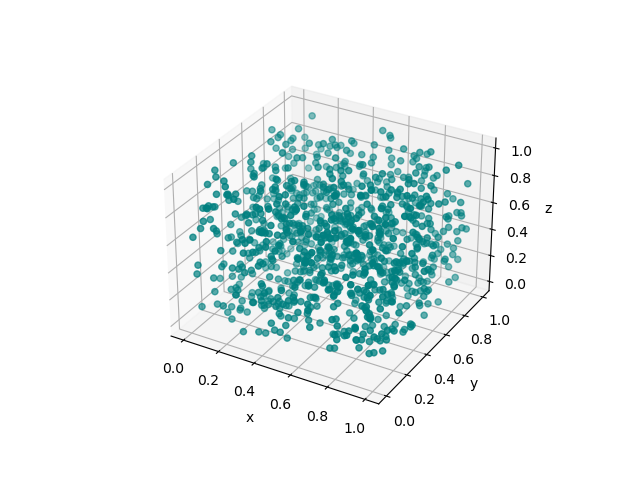

In [5]:
get_ipython().magic('matplotlib notebook')
fig = plt.figure()

def generate_random_uniform_points_three_dimensions(number_of_points):
    """
    Generates a 2D array of random uniformly distributed points between the values of 0 and 1 using numpy.random.uniform.
    The size of the array in each dimension is given by the number_of_points parameter.
    
    Parameters
    ----------
    number_of_points : float
        A parameter defining how big the 2D array should be. For example, if number_of_points = 10, the output will be a 
        10 x 10 array.
        
    Returns
    -------
    points: array
        A 2D array of uniform randomly distributed points. The size of this array is given by number_of_points.
    """
    
    xpoints = np.random.uniform(low = 0, high = 1.0, size = (number_of_points))
    ypoints = np.random.uniform(low = 0, high = 1.0, size = (number_of_points))
    zpoints = np.random.uniform(low = 0, high = 1.0, size = (number_of_points))
    
    return xpoints, ypoints, zpoints

euclidean_space_xpoints, euclidean_space_ypoints, euclidean_space_zpoints = \
    generate_random_uniform_points_three_dimensions(1000)

euclidean_space_graph = fig.add_subplot(111, projection = '3d')
euclidean_space_graph.scatter(euclidean_space_xpoints, euclidean_space_ypoints, euclidean_space_zpoints, color = 'teal')
euclidean_space_graph.set_xlabel('x')
euclidean_space_graph.set_ylabel('y')
euclidean_space_graph.set_zlabel('z')
plt.show()

It can be seen by examining this plot that there are no spectral issues caused by 'np.random.uniform()'.

## Demonstrating spectral issues caused by randssp

In [6]:
# get_ipython().magic('matplotlib notebook')
# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')

# def randssp(p,q):
    
#     global m, a, c, x
        
#     try: x
#     except NameError:
#         m = pow(2, 31)
#         a = pow(2, 16) + 3
#         c = 0
#         x = 123456789
    
#     try: p
#     except NameError:
#         p = 1
#     try: q
#     except NameError:
#         q = p
    
#     r = np.zeros([p,q])

#     for l in range (0, q):
#         for k in range (0, p):
#             x = np.mod(a*x + c, m)
#             r[k, l] = x/m
    
#     return r

# k = randssp(3, 1500)
# ax.scatter(k[0, :], k[1, :], k[2, :], color='r')

# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# plt.show()

## exponential distribution

Wall time: 0 ns


<IPython.core.display.Javascript object>


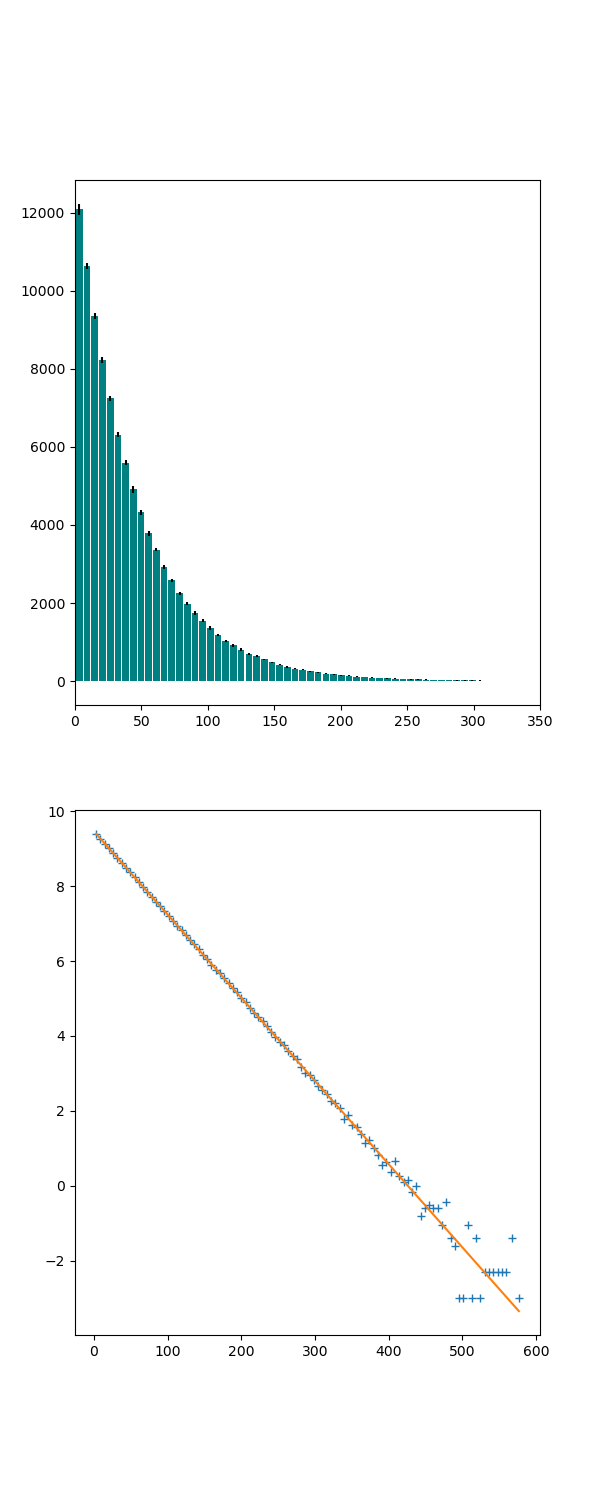

Measured mean free path = (45.0097 ± 0.0008) cm


C:\Users\ellab\AppData\Local\Temp\ipykernel_9188\813293415.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  water_histograms = np.array([i.result() for i in histograms])


In [7]:
%time
fig = plt.figure(figsize = (6,15))
histogram = fig.add_subplot(211)
logplot = fig.add_subplot(212)


estimated_attenuation_length_water = 1 / 45 #cm

def sampling_exponential_distribution(mean_free_path, number_of_points):
    samples = np.random.uniform(low = 0, high = 1.0, size = (number_of_points))
    exponential_samples = (-1 * mean_free_path) * np.log(samples)
    
    return exponential_samples

def generate_histogram(data, min_value, max_value, number_of_bins):
    histogram, bins = np.histogram(data, bins = number_of_bins, range = (min_value, max_value))
    return histogram, bins

def linear_function(x, m, c):
    y = (m * x) + c
    return y
    

estimated_mean_free_path_water = 1 / estimated_attenuation_length_water

def generate_histograms(number_of_tests, mean_free_path, number_of_points, number_of_bins):
    
    #producing 20 sets of data simultaneously
    with concurrent.futures.ThreadPoolExecutor() as executor:
        data = [executor.submit(sampling_exponential_distribution, mean_free_path, number_of_points) for i in 
        range(number_of_tests)]
    
    #result gives 2D array of every data point, look for the maximum value and flatten into 1D array (to use in 'plt.hist()'')
    histogram_data = np.array([i.result() for i in data])
    max_value = np.max(histogram_data)
    flat_data = histogram_data.flatten()
    
    #generating occupancies of every bin for each data set
    #note: having the range between 0 and 'max_value' ensures the bins are the same for each data set
    with concurrent.futures.ThreadPoolExecutor() as executor:
        histograms = [executor.submit(generate_histogram, histogram_data[i, :], 0, max_value, number_of_bins) for i in 
        range(number_of_tests)]
    
    #result gives array of bins and occupancies, separating these:
    water_histograms = np.array([i.result() for i in histograms])
    hist = np.dstack(water_histograms[:, 0])[0]
    bins = np.dstack(water_histograms[:, 1])[0][:, 0]#only need to use 1 column as each array of bins is identical
    
    #finding average occupancies for each bin across all data sets
    average_occupancies = np.array([np.sum(hist[i, :] / number_of_tests) for i in range(len(bins) - 1)])
    std_occupancies = np.array([np.std(hist[i, :]) for i in range(len(bins) - 1)])
    
    return flat_data, average_occupancies, std_occupancies, bins

data_points, occupancies, std, bins = generate_histograms(20,45,100000, 100)

#plotting histogram
#histogram.hist(data_points, bins=100, color = 'teal', edgecolor = 'white')
histogram.bar(bins[1:], occupancies, width = -5, align = 'edge', yerr = std, color = 'teal')
histogram.set_xlim((0, 350))

# #plotting log plot
empty_bins = np.where(occupancies == 0)
justified_water_population = np.delete(occupancies, empty_bins)
justified_std = np.delete(std, empty_bins)
justified_bins = np.delete(bins, empty_bins)

bin_centres = np.zeros((len(justified_bins) - 1))
bin_centres = np.array([((justified_bins[i+1] + justified_bins[i]) / 2) for i in range(len(justified_bins) - 1)])

population_logs = np.log(justified_water_population)
logplot_parameters, cov = np.polyfit(bin_centres, population_logs, 1, w = (justified_water_population / justified_std), cov = True)

actual_mean_free_path = -1 / logplot_parameters[0]
actual_mean_free_path_error = np.sqrt(cov[0,0]) / logplot_parameters[0]
print(u"Measured mean free path = ({0:.4f} \u00B1 {1:.4f}) cm".format(actual_mean_free_path, np.abs(actual_mean_free_path_error)))

line_of_best_fit = linear_function(bin_centres, logplot_parameters[0], logplot_parameters[1])
plt.plot(bin_centres, population_logs, '+')
plt.plot(bin_centres, line_of_best_fit)


plt.show()

## Producing isotropic unit vectors

<IPython.core.display.Javascript object>


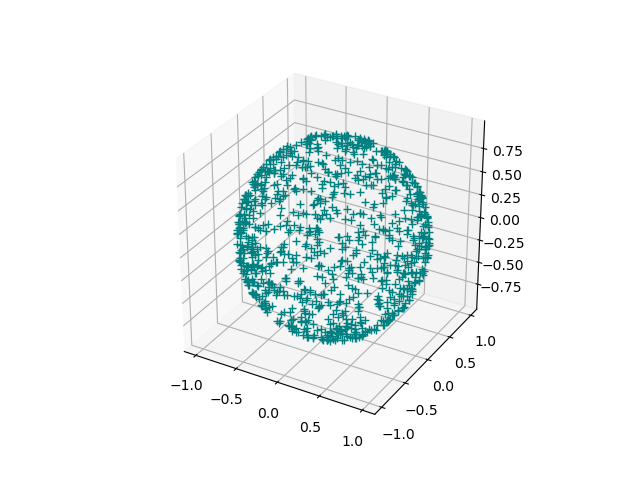

In [8]:
fig = plt.figure()
unit_vectors_plot = fig.add_subplot(111, projection = '3d')

def produce_unit_vectors(number_of_vectors, magnitude):
    
    arbitrary_value = np.random.uniform(low = 0, high = 1, size = number_of_vectors)
    theta = np.arccos(1 - (2 * arbitrary_value))
    
    phi = np.random.uniform(low = 0, high = (2 * np.pi), size = number_of_vectors)
    
    x = magnitude * np.sin(theta) * np.cos(phi)
    y = magnitude * np.sin(theta) * np.sin(phi)
    z = magnitude * np.cos(theta)
    
    vector_magnitude = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    
    return x, y, z, vector_magnitude
xvalues, yvalues, zvalues, magnitudes = produce_unit_vectors(1000, 1)

unit_vectors_plot.plot(xvalues, yvalues, zvalues, '+', color = 'teal')
unit_vectors_plot.set_box_aspect((1, 1, 1))
plt.show()

## Creating isotropic steps

<IPython.core.display.Javascript object>


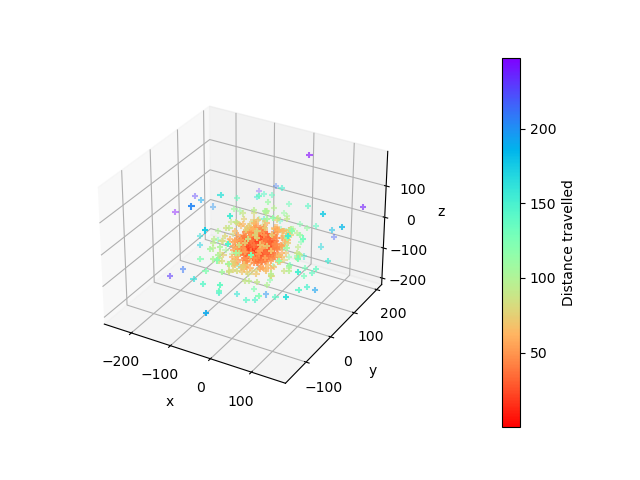

In [9]:
fig = plt.figure()
steps_graph = fig.add_subplot(111, projection = '3d')

def isotropic_steps(mean_free_path, number_of_steps):
    distances = sampling_exponential_distribution(mean_free_path, number_of_steps)
    x_coordinate, y_coordinate, z_coordinate, magnitudes = produce_unit_vectors(number_of_steps, distances)
    
    return x_coordinate, y_coordinate, z_coordinate, magnitudes

x, y, z, magnitudes = isotropic_steps(estimated_mean_free_path_water, 1000)

# distances = sampling_exponential_distribution(estimated_mean_free_path_water, 1000)
# x_coordinate, y_coordinate, z_coordinate, magnitudes = produce_unit_vectors(1000, distances)

plot = steps_graph.scatter(x, y, z, c = magnitudes, marker = '+', cmap = 'rainbow_r')
steps_graph.set_xlabel('x')
steps_graph.set_ylabel('y')
steps_graph.set_zlabel('z')
cbar = fig.colorbar(plot, pad = 0.2)
cbar.set_label('Distance travelled')
plt.show()

## Random Walk

<IPython.core.display.Javascript object>


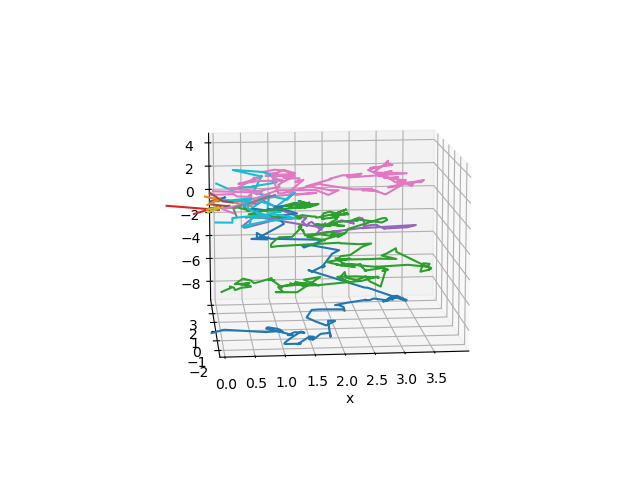

18 2 0


In [49]:
fig = plt.figure()
walk_graph = fig.add_subplot(111, projection = '3d')

particles_reflected = 0
particles_absorbed = 0
particles_transmitted = 0

def calculate_parameters(absorption_coeff, scattering_coeff, density, molar_mass):
    
    particle_density = density * avogadro_const / molar_mass
    
    macroscopic_absorption_coeff = particle_density * absorption_coeff
    macroscopic_scattering_coeff = particle_density * scattering_coeff
    
    mean_free_path = 1 / ((particle_density * absorption_coeff) + (particle_density * scattering_coeff))
    
    return particle_density, macroscopic_absorption_coeff, macroscopic_scattering_coeff, mean_free_path

# particle_density_water, macroscopic_absorption_coeff_water, macroscopic_scattering_coeff_water, mean_free_path_water = \
# calculate_parameters(water_absorption_coeff, water_scattering_coeff, water_density, water_molar_mass)

# particle_density_lead, macroscopic_absorption_coeff_lead, macroscopic_scattering_coeff_lead, mean_free_path_lead = \
# calculate_parameters(lead_absorption_coeff, lead_scattering_coeff, lead_density, lead_molar_mass)

# particle_density_graphite, macroscopic_absorption_coeff_graphite, macroscopic_scattering_coeff_graphite,\
# mean_free_path_graphite = calculate_parameters(graphite_absorption_coeff, graphite_scattering_coeff, graphite_density, 
# graphite_molar_mass)

# absorption_probability_water = macroscopic_absorption_coeff_water / (macroscopic_absorption_coeff_water + \
#     macroscopic_scattering_coeff_water)
# absorption_probability_lead = macroscopic_absorption_coeff_lead / (macroscopic_absorption_coeff_lead + \
#     macroscopic_scattering_coeff_lead)
# absorption_probability_graphite = macroscopic_absorption_coeff_graphite / (macroscopic_absorption_coeff_graphite + \
#     macroscopic_scattering_coeff_graphite)

# particles_reflected = 0
# particles_absorbed = 0
# particles_transmitted = 0

def random_walk(thickness, mean_free_path, absorption_probability):
    global particles_reflected, particles_absorbed, particles_transmitted
    
    initial_x = -1 * mean_free_path * np.log(np.random.uniform(size = 1))
    initial_coordinates = [initial_x, float(np.random.uniform(size = 1)), float(np.random.uniform(size = 1))]
    random_walk = np.reshape(initial_coordinates, (1,3))
        
    while 0 <= random_walk[-1][0] <= thickness:
        x, y, z, magnitude = isotropic_steps(mean_free_path, 1)
        new_x = random_walk[-1][0] + x
        new_y = random_walk[-1][1] + y
        new_z = random_walk[-1][2] + z
            
        new_coordinates = np.array([float(new_x), float(new_y), float(new_z)])
        random_number = np.random.uniform(size = 1)
        
            
        if random_number < absorption_probability:
            particles_absorbed += 1
            return random_walk
            
        else:
            random_walk = np.vstack((random_walk, new_coordinates))
    
    if random_walk[-1][0] < 0:
        particles_reflected += 1
        
    if random_walk[-1][0] > thickness:
        particles_transmitted += 1
                
    return random_walk[:, 0], random_walk[:, 1], random_walk[:, 2]

def random_walks(number_of_walks, thickness, mean_free_path, absorption_probability):
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        data = [executor.submit(random_walk, thickness, mean_free_path, absorption_probability) for i in 
        range(number_of_walks)]
    

    random_walks = [i.result() for i in data]

    return random_walks, particles_reflected, particles_absorbed, particles_transmitted

particle_density_water, macroscopic_absorption_coeff_water, macroscopic_scattering_coeff_water, mean_free_path_water = \
calculate_parameters(water_absorption_coeff, water_scattering_coeff, water_density, water_molar_mass)

particle_density_lead, macroscopic_absorption_coeff_lead, macroscopic_scattering_coeff_lead, mean_free_path_lead = \
calculate_parameters(lead_absorption_coeff, lead_scattering_coeff, lead_density, lead_molar_mass)

particle_density_graphite, macroscopic_absorption_coeff_graphite, macroscopic_scattering_coeff_graphite,\
mean_free_path_graphite = calculate_parameters(graphite_absorption_coeff, graphite_scattering_coeff, graphite_density, 
graphite_molar_mass)

absorption_probability_water = macroscopic_absorption_coeff_water / (macroscopic_absorption_coeff_water + \
    macroscopic_scattering_coeff_water)
absorption_probability_lead = macroscopic_absorption_coeff_lead / (macroscopic_absorption_coeff_lead + \
    macroscopic_scattering_coeff_lead)
absorption_probability_graphite = macroscopic_absorption_coeff_graphite / (macroscopic_absorption_coeff_graphite + \
    macroscopic_scattering_coeff_graphite)

while True:
    try:
        particles_reflected = 0
        particles_absorbed = 0
        particles_transmitted = 0
        
        test = random_walks(20, 10, mean_free_path_water, absorption_probability_water)
        print(particles_reflected, particles_absorbed, particles_transmitted)

        for i in range(20):
            xvals = test[0][i][0]
            yvals = test[0][i][1]
            zvals = test[0][i][2]
            walk_graph.plot(xvals, yvals, zvals)
    
        break
    
    except IndexError:
        pass

walk_graph.set_xlim(0)
walk_graph.set_xlabel('x')
plt.show()

## Lots of random walks

In [50]:
particles_reflected = 0
particles_absorbed = 0
particles_transmitted = 0
        
def tally_error(number_of_runs, number_of_walks, thickness, mean_free_path, absorption_probability):
    reflected_neutrons_array = np.zeros((number_of_runs))
    absorbed_neutrons_array = np.zeros((number_of_runs))
    transmitted_neutrons_array = np.zeros((number_of_runs))
        
    for i in range(number_of_runs):
        data = random_walks(number_of_walks, thickness, mean_free_path, absorption_probability)
        reflected_neutrons_array[i] = data[1] - np.sum(reflected_neutrons_array)
        absorbed_neutrons_array[i] = data[2] - np.sum(absorbed_neutrons_array)
        transmitted_neutrons_array[i] = data[3] - np.sum(transmitted_neutrons_array)
    
    mean_reflected = np.mean(reflected_neutrons_array)
    reflected_error = np.std(reflected_neutrons_array)
    
    mean_absorbed = np.mean(absorbed_neutrons_array)
    absorbed_error = np.std(absorbed_neutrons_array)
    
    mean_transmitted = np.mean(transmitted_neutrons_array)
    transmitted_error = np.std(transmitted_neutrons_array)
    
    return mean_reflected, reflected_error, mean_absorbed, absorbed_error, mean_transmitted, transmitted_error

def produce_results_statement(material_name, number_of_runs, number_of_walks, thickness, mean_free_path, absorption_probability):
    global particles_reflected, particles_absorbed, particles_transmitted
    particles_reflected = 0
    particles_absorbed = 0
    particles_transmitted = 0
    
    rates = tally_error(number_of_runs, number_of_walks, thickness, mean_free_path, absorption_probability)
    
    print('------------------------------------------------')
    print("Transmission Through A Fixed Thickness: {0}".format(material_name))
    print('------------------------------------------------')
    print("Total Neutrons = {0}".format((number_of_runs * number_of_walks)))
    print("Neutrons Reflected = {0} \u00B1 {1}".format(int(rates[0] * 10), round(rates[1] * 10)))
    print("Neutrons Absorbed = {0} \u00B1 {1}".format(int(rates[2] * 10), round(rates[3] * 10)))
    print("Neutrons Transmitted = {0} \u00B1 {1}".format(int(rates[4] * 10), round(rates[5] * 10)))
    print("Percentage Transmitted = ({0:.3f} \u00B1 {1:.3f}) %".format((rates[4] / 100), (rates[5] / 100)))
    
    return None

produce_results_statement("Water", 10, 1000, 10, mean_free_path_water, absorption_probability_water)
produce_results_statement("Lead", 10, 1000, 10, mean_free_path_lead, absorption_probability_lead)
produce_results_statement("Graphite", 10, 1000, 10, mean_free_path_graphite, absorption_probability_graphite)

------------------------------------------------
Transmission Through A Fixed Thickness: Water
------------------------------------------------
Total Neutrons = 10000
Neutrons Reflected = 7993 ± 98
Neutrons Absorbed = 1978 ± 89
Neutrons Transmitted = 29 ± 16
Percentage Transmitted = (0.029 ± 0.016) %
------------------------------------------------
Transmission Through A Fixed Thickness: Lead
------------------------------------------------
Total Neutrons = 10000
Neutrons Reflected = 6240 ± 140
Neutrons Absorbed = 983 ± 64
Neutrons Transmitted = 2777 ± 147
Percentage Transmitted = (2.777 ± 0.147) %
------------------------------------------------
Transmission Through A Fixed Thickness: Graphite
------------------------------------------------
Total Neutrons = 10000
Neutrons Reflected = 6824 ± 139
Neutrons Absorbed = 95 ± 32
Neutrons Transmitted = 3081 ± 138
Percentage Transmitted = (3.081 ± 0.138) %
